This notebook implements supervised weights for approximating the solution to the one-dimensional Gross-Pitavskii equation.

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.autograd import grad
from scipy.special import hermite

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Physics Informed Neural Network

In [2]:
class GrossPitaevskiiPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross-Pitaevskii Equation.
    """

    def __init__(self, layers, hbar=1.0, m=1.0, g=100.0, mode=0, prev_prediction=None):
        """
        Parameters
        ----------
        layers : list of int
            Neural network architecture, each entry defines the number of neurons in that layer.
        hbar : float, optional
            Reduced Planck's constant (default is 1.0).
        m : float, optional
            Mass of the particle (default is 1.0).
        g : float, optional
            Interaction strength (default is 100.0).
        mode : int, optional
            Mode number (default is 0).
        prev_prediction : callable, optional
            A function representing the previous model's forward pass, used to incorporate past solutions
            when computing the current solution (default is None).
        """
        super().__init__()
        self.layers = layers
        self.network = self.build_network()
        self.g = g  # Interaction strength
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed
        self.mode = mode  # Mode number (n)
        self.prev_prediction = prev_prediction  # Store previous predictions

    def build_network(self):
        """
        Build the neural network with sine activation functions between layers.

        Returns
        -------
        nn.Sequential
            A PyTorch sequential model representing the neural network architecture.
        """
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            if i < len(self.layers) - 2:
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def weighted_hermite(self, x, n):
        """
        Compute the weighted Hermite polynomial solution for the linear case (gamma = 0).
        Equation (34) in https://www.sciencedirect.com/science/article/abs/pii/S0010465513001318.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of spatial coordinates (collocation points) or boundary points.
        n : int
            Mode of ground state solution to Gross-Pitavskii equation (0 for base ground state)

        Returns
        -------
        torch.Tensor
            The weighted Hermite polynomial solution for the linear case (gamma = 0).
        """
        H_n = hermite(n)(x.cpu().detach().numpy())  # Hermite polynomial evaluated at x
        norm_factor = (2**n * math.factorial(n) * np.sqrt(np.pi))**(-0.5)
        weighted_hermite = norm_factor * torch.exp(-x**2 / 2) * torch.tensor(H_n, dtype=torch.float32).to(device)

        return weighted_hermite

    def forward(self, inputs):
        """
        Forward pass through the neural network.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor containing spatial points (collocation points).

        Returns
        -------
        torch.Tensor
            Output tensor representing the predicted solution.
        """
        return self.network(inputs)

    def compute_potential(self, x, potential_type="harmonic", **kwargs):
        """
        Compute a symmetric or asymmetric potential function for the 1D domain.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of spatial coordinates.
        potential_type : str, optional
            Type of potential. Options are: "harmonic".
        kwargs : dict
            Additional parameters specific to each potential type.

        Returns
        -------
        V : torch.Tensor
            Tensor of potential values at the input points.

        Raises
        ------
        ValueError
            If the potential type is not recognized.
        """
        if potential_type == "harmonic":
            omega = kwargs.get('omega', 1.0)  # Frequency for harmonic potential
            V = 0.5 * omega ** 2 * x ** 2
        elif potential_type == "gaussian":
            a = kwargs.get('a', 0.0)  # Center of the Gaussian
            V = torch.exp(-(x - a) ** 2)
        elif potential_type == "periodic":
            V0 = kwargs.get('V0', 1.0)  # Depth of the potential
            k = kwargs.get('k', 2 * np.pi / 5.0)  # Wave number for periodic potential
            V = V0 * torch.cos(k * x) ** 2
        else:
            raise ValueError(f"Unknown potential type: {potential_type}")

        return V

    def compute_thomas_fermi_approx(self, lambda_pde, potential, eta):
        """
        Calculate the Thomas–Fermi approximation for the given potential.

        Parameters
        ----------
        lambda_pde : float
            Eigenvalue from lowest enegry ground state.
        potential : torch.Tensor
            Potential values corresponding to the spatial coordinates.
        eta : float
            Interaction strength.

        Returns
        -------
        torch.Tensor
            Thomas–Fermi approximation of the wave function.
        """
        tf_approx = torch.sqrt(torch.relu((lambda_pde - potential) / eta))
        return tf_approx

    def boundary_loss(self, boundary_points, boundary_values, prev_prediction=None):
        """
        Compute the boundary loss (MSE) for the boundary conditions.

        Parameters
        ----------
        boundary_points : torch.Tensor
            Input tensor of boundary spatial points.
        boundary_values : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.

        Returns
        -------
        torch.Tensor
            Mean squared error (MSE) at the boundary points.
        """
        u_pred = self.forward(boundary_points)

        if prev_prediction is None:
            u = self.weighted_hermite(boundary_points, self.mode) + u_pred
        else:
            u = prev_prediction(boundary_points) + u_pred  # Use model’s output from previous eta

        return torch.mean((u - boundary_values) ** 2)

    def riesz_loss(self, predictions, inputs, eta, potential_type, precomputed_potential=None, prev_prediction=None, p=2):
        """
        Compute the Riesz energy loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        predictions : torch.Tensor
            Predicted solution from the network.
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        eta : float
            Interaction strength.
        potential_type : str
            Type of potential function to use.
        precomputed_potential : torch.Tensor
            Precomputed potential. Default is None.
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.
        p : int
            Nonlinearity power. Default is 2.

        Returns
        -------
        torch.Tensor
            Riesz energy loss value.
        """
        if prev_prediction is None:
            u = self.weighted_hermite(inputs, self.mode) + predictions
        else:
            scaling_factor = torch.sqrt(torch.tensor(eta, dtype=torch.float32, device=device))
            u = prev_prediction(inputs) + predictions  # Use model’s output from previous eta

        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        u_x = torch.autograd.grad(outputs=u, inputs=inputs,
                                  grad_outputs=torch.ones_like(predictions),
                                  create_graph=True, retain_graph=True)[0]

        laplacian_term = torch.mean(u_x ** 2)  # Kinetic term
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)
        potential_term = torch.mean(V * u ** 2)  # Potential term
        interaction_term = (2 * eta / (p + 1)) * torch.mean(torch.abs(u) ** (p + 1))

        riesz_energy = 0.5 * (laplacian_term + potential_term + interaction_term)

        return riesz_energy

    def pde_loss(self, inputs, predictions, eta, potential_type, precomputed_potential=None, prev_prediction=None, p=2):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        predictions : torch.Tensor
            Predicted solution from the network.
        eta : float
            Interaction strength.
        potential_type : str
            Type of potential function to use.
        precomputed_potential : torch.Tensor
            Precomputed potential. Default is None.
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.
        p : int
            Nonlinearity power. Default is 2.

        Returns
        -------
        tuple
            Tuple containing:
                - torch.Tensor: PDE loss value.
                - torch.Tensor: PDE residual.
                - torch.Tensor: Smallest eigenvalue (lambda).
        """
        if prev_prediction is None:
            u = self.weighted_hermite(inputs, self.mode) + predictions
        else:
            scaling_factor = torch.sqrt(torch.tensor(eta, dtype=torch.float32, device=device))
            u = prev_prediction(inputs) + predictions  # Use model’s output from previous eta

        # Compute first and second derivatives with respect to x
        u_x = grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        # Compute λ from the energy functional
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)
        lambda_pde = torch.mean(u_x ** 2 + V * u ** 2 + eta * torch.abs(u) ** (p+1)) / torch.mean(u ** 2)

        # Residual of the 1D Gross-Pitaevskii equation
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)
        pde_residual = -u_xx + V * u + eta * torch.abs(u) ** (p - 1) * u - lambda_pde * u

        # Regularization: See https://arxiv.org/abs/2010.05075

        # Term 1: L_f = 1 / (f(x, λ))^2, penalizes the network if the PDE residual is close to zero to avoid trivial eigenfunctions
        L_f = 1 / (torch.mean(u ** 2) + 1e-2)

        # Term 2: L_λ = 1 / λ^2, penalizes small eigenvalues λ, ensuring non-trivial eigenvalues
        L_lambda = 1 / (lambda_pde ** 2 + 1e-6)

        # Term 3: L_drive = e^(-λ + c), encourages λ to grow, preventing collapse to small values
        L_drive = torch.exp(-lambda_pde + 1.0)

        # PDE loss (residual plus regularization terms)
        pde_loss = torch.mean(pde_residual ** 2)  # + L_lambda + L_f

        return pde_loss, pde_residual, lambda_pde

    def symmetry_loss(self, collocation_points, lb, ub):
        """
        Compute the symmetry loss to enforce u(x) = u((a+b)-x).

        Parameters
        ----------
        collocation_points : torch.Tensor
            Tensor of interior spatial points.
        lb : torch.Tensor
            Lower bound of interval.
        ub: torch.Tensor
            Upper bound of interval.

        Returns
        -------
        sym_loss : torch.Tensor
            The mean squared error enforcing symmetry u(x) = u((a+b)-x).
        """
        # Reflect points across the center of the domain
        x_reflected = (lb + ub) - collocation_points

        # Evaluate u(x) and u((a+b)-x)
        u_original = self.forward(collocation_points)
        u_reflected = self.forward(x_reflected)

        # Compute MSE to enforce symmetry
        sym_loss = torch.mean((u_original - u_reflected) ** 2)
        return sym_loss

    def total_loss(self, collocation_points, boundary_points, boundary_values, eta, lb, ub, weights, potential_type,
                   precomputed_potential=None, prev_prediction=None, p=2):
        """
        Compute the total loss combining boundary loss, Riesz energy loss,
        PDE loss, L^2 norm regularization loss, and symmetry loss.

        Parameters
        ----------
        collocation_points : torch.Tensor
            Input tensor of spatial coordinates for the interior points.
        boundary_points : torch.Tensor
            Input tensor of boundary spatial points.
        boundary_values : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).
        eta : float
            Interaction strength.
        lb : torch.Tensor
            Lower bound of interval.
        ub : torch.Tensor
            Upper bound of interval.
        weights : list
            Weights for different loss terms.
        potential_type : str
            Type of potential function to use
        precomputed_potential : torch.Tensor
            Precomputed potential. Default is None.
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.
        p : int
            Nonlinearity power. Default is 2.

        Returns
        -------
        total_loss : torch.Tensor
            Total loss value.
        """

        # Use precomputed potential if provided
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(collocation_points, potential_type)

        # Compute individual loss components
        data_loss = self.boundary_loss(boundary_points, boundary_values, prev_prediction)
        riesz_energy_loss = self.riesz_loss(self.forward(collocation_points), collocation_points, eta, potential_type,V, prev_prediction, p)
        pde_loss, _, _ = self.pde_loss(collocation_points, self.forward(collocation_points), eta, potential_type, V, prev_prediction, p)
        norm_loss = (torch.norm(self.forward(collocation_points), p=2) - 1) ** 2
        sym_loss = self.symmetry_loss(collocation_points, lb, ub)

        # Scaling factor for pde loss and riesz energy loss
        domain_length = ub - lb

        # Compute weighted losses and total loss
        losses = [data_loss, riesz_energy_loss  / domain_length, pde_loss / domain_length, norm_loss, sym_loss]
        weighted_losses = [weights[i] * loss for i, loss in enumerate(losses)]
        total_loss = sum(weighted_losses)

        return total_loss, data_loss, riesz_energy_loss, pde_loss, norm_loss

# Initialize Weights

In [3]:
def initialize_weights(m):
    """
    Initialize the weights of the neural network layers using Xavier uniform initialization.

    Parameters
    ----------
    m : torch.nn.Module
        A layer of the neural network. If it is a linear layer, its weights and biases are initialized.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Prepare Training Data

In [4]:
def prepare_training_data(N_u, N_f, lb, ub):
    """
    Prepare boundary and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points.
    lb : np.ndarray
        Lower bounds of the domain.
    ub : np.ndarray
        Upper bounds of the domain.

    Returns
    -------
    collocation_points : np.ndarray
        Collocation points.
    boundary_points : np.ndarray
        Boundary points.
    boundary_values : np.ndarray
        Boundary values.
    """

    # Boundary of interval
    boundary_points = np.array([[lb], [ub]])
    boundary_values = np.zeros((2, 1))

    # Dynamically sample points inside the interval
    collocation_points = np.random.rand(N_f, 1) * (ub - lb) + lb

    return collocation_points, boundary_points, boundary_values

# Train PINN

In [5]:
def train_pinn(X, N_u, N_f, layers, eta, epochs, lb, ub, weights, model_save_path, potential_type, prev_prediction, p):
    """
    Train the Physics-Informed Neural Network (PINN) for the 1D Gross-Pitaevskii equation.

    Parameters
    ----------
    X : np.ndarray
        Input data for the neural network
    N_u : int
        Number of boundary points
    N_f : int
        Number of collocation points (interior points) for the physics-based loss
    layers : list of int
        Architecture of the neural network
    eta : float
        Interaction strength
    epochs: int
        Number of epochs
    lb : int
        Lower bound of interval.
    ub : int
        Upper bound of interval.
    weights : list
        Weights for different loss terms.
    model_save_path : str
        Save path for trained model
    potential_type: str
        Type of potential function to use
    prev_prediction : GrossPitaevskiiPINN or None
        Previously trained model whose predictions are used as part of the training process.
        If None, the model starts training from scratch.
    p : int
        Nonlinearity power

    Returns
    -------
    model : GrossPitaevskiiPINN
        The trained model
    loss_history : list
        List of loss values recorded during training
    """
    # Instantiate the PINN model and initialize its weights
    model = GrossPitaevskiiPINN(layers).to(device)
    model.apply(initialize_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, factor=0.5, verbose=True)

    # Prepare training data (collocation and boundary points)
    collocation_points, boundary_points, boundary_values = prepare_training_data(N_u, N_f, lb, ub)

    # Convert data to PyTorch tensors and move to device
    collocation_points_tensor = torch.tensor(collocation_points, dtype=torch.float32, requires_grad=True).to(device)
    boundary_points_tensor = torch.tensor(boundary_points, dtype=torch.float32).to(device)
    boundary_values_tensor = torch.tensor(boundary_values, dtype=torch.float32).to(device)
    lb_tensor = torch.tensor(lb, dtype=torch.float32).to(device)
    ub_tensor = torch.tensor(ub, dtype=torch.float32).to(device)

    # Precompute potential
    V = model.compute_potential(collocation_points_tensor, potential_type).detach()
    V.requires_grad = False

    # Precompute Thomas-Fermi approximation
    #tf_approx = model.compute_thomas_fermi_approx(collocation_points_tensor, V, eta).detach()
    #tf_approx.requires_grad = False

    loss_history = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Calculate the total loss (boundary, Riesz energy, PDE, normalization, and symmetry losses)
        # with precomputed potential and Thomas-Fermi approximation
        loss, data_loss, riesz_energy, pde_loss, norm_loss = model.total_loss(collocation_points_tensor,
                                                                              boundary_points_tensor,
                                                                              boundary_values_tensor,
                                                                              eta,
                                                                              lb_tensor, ub_tensor,
                                                                              weights, potential_type, V,
                                                                              prev_prediction, p)

        # Backpropagation and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        optimizer.step()

        # Scheduler step (for ReduceLROnPlateau)
        scheduler.step(loss)

        # Record the total loss every 100 epochs
        if epoch % 100 == 0:
            loss_history.append(loss.item())

        # Compute λ_PDE every 1,000 epochs
        if epoch % 1000 == 0:
            pde_loss, _, lambda_pde = model.pde_loss(collocation_points_tensor,
                                                     model.forward(collocation_points_tensor),
                                                     eta, potential_type, p)
            print(f"Epoch {epoch}: λ_PDE = {lambda_pde.item():.6f}, η = {eta}, Loss: {loss.item():.6f}")

        # Record the loss every 10,000 epochs
        if epoch % 10000 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}')

    return model, loss_history

# Normalize Wave Function


In [6]:
def normalize_wave_function(u):
    """
    Normalize the wave function with respect to its maximum value.

    Parameters
    ----------
    u : torch.Tensor
        The predicted wave function.

    Returns
    -------
    torch.Tensor
        The normalized wave function.
    """
    return np.abs(u) / np.max(np.abs(u))

# Plot Potential

In [7]:
def plot_potential_1D(X_test, potential):
    """
    Plot the 1D potential function.

    Parameters
    ----------
    X_test : np.ndarray
        The test points where the potential is computed.
    potential : np.ndarray
        The computed potential values at the test points.
    """
    plt.figure(figsize=(6, 5))

    # X_test is the x-values (positions) of the 1D potential
    plt.plot(X_test, potential, label='Potential $V(x)$', color='green')

    plt.title('Potential $V(x)$ in 1D')
    plt.xlabel('$x$')
    plt.ylabel('$V(x)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Train and Save PINN

In [8]:
def train_and_save_pinn(X, N_u, N_f, layers, eta, epochs, lb, ub, weights, model_save_path, potential_type, prev_model, p):
    """
    Train the Physics-Informed Neural Network (PINN) model and save it.

    This function trains a PINN model for the 1D Gross-Pitaevskii equation with a specific interaction
    strength (eta) and saves the trained model to a specified path. It also returns the trained model
    and the loss history recorded during training.

    Parameters
    ----------
    X : np.ndarray
        Input data for the training (e.g., spatial domain points).
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points (interior points) for physics-based loss.
    layers : list of int
        Architecture of the neural network, defined as a list of layer sizes.
        For example, [1, 100, 100, 100, 1] represents an input layer with 1 neuron,
        three hidden layers with 20 neurons each, and an output layer with 1 neuron.
    eta : float
        Interaction strength parameter for the Gross-Pitaevskii equation.
    epochs : int
        Number of training epochs.
    lb : int
        Lower bound of interval.
    ub : int
        Upper bound of interval.
    weights : list
        Weights for different loss terms.
    model_save_path : str
        File name to save the trained model weights (e.g., 'model_eta_1.pth').
    potential_type: str
        Type of potential function to use
    prev_model : GrossPitaevskiiPINN or None
        Previously trained model whose predictions are used as part of the training process.
        If None, the model starts training from scratch.
    p : int
        nonlinearity power

    Returns
    -------
    model : GrossPitaevskiiPINN
        The trained PINN model.
    loss_history : list of float
        A list of loss values recorded during training for each epoch
    """

    # Create a new model, passing the previous model's forward function if available
    prev_prediction = prev_model.forward if prev_model is not None else None
    if prev_model is not None:
        prev_model.eval()
    model = GrossPitaevskiiPINN(layers, prev_prediction=prev_prediction).to(device)
    model.apply(initialize_weights)

    # Train the model
    model, loss_history = train_pinn(X, N_u=N_u, N_f=N_f, layers=layers, eta=eta, epochs=epochs, lb=lb, ub=ub,
                                     weights=weights, model_save_path=model_save_path, potential_type=potential_type,
                                     prev_prediction=prev_prediction, p=p)

    # Directory to save the models
    model_save_dir = 'models'
    os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Save model after training
    save_model_path = os.path.join(model_save_dir, model_save_path)
    torch.save(model.state_dict(), save_model_path)  # Save model weights

    return model, loss_history

# Predict and Plot

In [9]:
def predict_and_plot(models, etas, X_test, p=2, save_path='plots/predicted_solutions.png', potential_type='gaussian', prev_prediction=None):
    """
    Predict and plot the solutions for all models and save the plot.

    Parameters
    ----------
    models : list of models
        A list of trained models.
    etas : list of float
        A list of eta values corresponding to each model.
    X_test : np.ndarray
        Test points along the 1D interval.
    p : int
        Nonlinearity parameter. Default is 2.
    save_path : str, optional
        The path to save the plot image (default is 'plots/predicted_solutions.png').
    potential_type  : str, optional
        Type of potential function to use. Default is 'gaussian'.

    Returns
    -------
    None
    """
    # Ensure the plots directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.figure(figsize=(10, 6))
    for model, eta in zip(models, etas):
        model.eval()  # Set the model to evaluation mode

        # Prepare test data
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True).to(device)
        u_pred = model(X_test_tensor).detach().cpu().numpy()
        u_pred_normalized = normalize_wave_function(u_pred)

        # Calculate the potential
        potential = model.compute_potential(X_test_tensor, potential_type)

        # Calculate Thomas-Fermi approximation
        _, _, lambda_pde = model.pde_loss(X_test_tensor,
                                          model.forward(X_test_tensor), eta,
                                          potential_type, potential, prev_prediction, p=p)
        tf_approx = model.compute_thomas_fermi_approx(X_test_tensor, potential, eta).detach().cpu().numpy()
        tf_approx_normalized = normalize_wave_function(tf_approx)

        # Plot the predicted solution and TF approximation
        plt.plot(X_test, u_pred_normalized, label=f'Normalized Predicted Solution ($\\eta$ ≈ {eta})')
        # plt.plot(X_test, tf_approx_normalized, linestyle='--',
        #          label=f'Normalized Thomas-Fermi Approximation ($\\eta$ ≈ {eta})')

    # Calculate the weighted hermite approximation
    wh_approx = model.weighted_hermite(X_test_tensor, 0).detach().cpu().numpy()
    wh_approx_normalized = normalize_wave_function(wh_approx)

    plt.plot(X_test, wh_approx_normalized, linestyle='-.',
             label=f'Normalized Weighted Hermite Approximation ($\\eta$ = 0)')

    plt.title(
        f'PINN Ground State Solution and Weighted Hermite Approximation for p={p}\n'
        f'Potential Type: {potential_type.capitalize()}, Interaction Strengths: {etas}',
        fontsize="xx-large"
    )
    plt.xlabel('$x$', fontsize="xx-large")
    plt.ylabel('Normalized $u(x)$', fontsize="xx-large")
    plt.grid(True)
    plt.legend(fontsize="large")

    # Set larger tick sizes
    plt.xticks(fontsize="x-large")
    plt.yticks(fontsize="x-large")

    # Save the plot
    save_path = save_path.format(potential_type=potential_type)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot Loss History

In [10]:
def plot_loss_history(loss_histories, etas, nonlinearity_powers, save_path='plots/loss_history.png', potential_type='gaussian'):
    """
    Plot the training loss history for different values of eta and save the plot.

    Parameters
    ----------
    loss_histories : list of lists
        A list where each element is a list of loss values recorded during training
        for a specific eta.
    etas : list of float
        A list of eta values corresponding to each loss history.
    nonlinearity_powers : list of int
        List of p values (nonlinearity powers) used in training.
    save_path : str, optional
        The path to save the plot image (default is 'plots/loss_history.png').
    potential_type  : str, optional
        Type of potential function to use. Default is 'gaussian'.

    Returns
    -------
    None
    """
    # Ensure the plots directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.figure(figsize=(10, 6))
    cmap = plt.get_cmap("coolwarm", len(nonlinearity_powers))

    for i, p in enumerate(nonlinearity_powers):
        for loss_history, eta in zip(loss_histories[p], etas):
            color = cmap(i / len(nonlinearity_powers))
            plt.plot(loss_history, label=f'Loss ($p$={p}, $\\eta$={eta})', color=color, alpha=0.7)

    plt.xlabel('Training step (x 100)', fontsize="xx-large")
    plt.ylabel('Total Loss', fontsize="xx-large")
    plt.yscale('log')
    plt.title(f'Loss History for Different Interaction Strengths ($\\eta$) for {potential_type.capitalize()} Potential', fontsize="xx-large")
    plt.legend(fontsize="large")
    plt.grid(True)

    # Set larger tick sizes
    plt.xticks(fontsize="x-large")
    plt.yticks(fontsize="x-large")

    # Save the plot
    save_path = save_path.format(potential_type=potential_type)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Main

In [11]:
# Parameters
N_u = 200  # Number of boundary points
N_f = 4000  # Number of collocation points
epochs = 10001 # Number of iterations of training
layers = [1, 100, 100, 100, 1]  # Neural network architecture
lb, ub = -10, 10  # Boundary limits
X = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Input grid for training

# Test points
X_test = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Test points for prediction
etas = [1, 10, 50, 100]  # Interaction strengths

# Weights for loss terms
weights = [50.0, 1.0, 2.0, 10.0, 50.0]

# Loop through and plot all potential types for different values of the nonlinearity parameter $p$

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: λ_PDE = 1.719127, η = 1, Loss: 14368.978516
Epoch [0/10001], Loss: 14368.978516
Epoch 1000: λ_PDE = 2.120918, η = 1, Loss: 0.006757
Epoch 2000: λ_PDE = 2.120841, η = 1, Loss: 0.006756
Epoch 3000: λ_PDE = 2.120839, η = 1, Loss: 0.006756
Epoch 4000: λ_PDE = 2.120836, η = 1, Loss: 0.006756
Epoch 5000: λ_PDE = 2.120830, η = 1, Loss: 0.006756
Epoch 6000: λ_PDE = 2.120822, η = 1, Loss: 0.006755
Epoch 7000: λ_PDE = 2.120808, η = 1, Loss: 0.006755
Epoch 8000: λ_PDE = 2.120788, η = 1, Loss: 0.006755
Epoch 9000: λ_PDE = 2.120758, η = 1, Loss: 0.006755
Epoch 10000: λ_PDE = 2.120715, η = 1, Loss: 0.006754
Epoch [10000/10001], Loss: 0.006754
Epoch 0: λ_PDE = 8.989302, η = 10, Loss: 618.439575
Epoch [0/10001], Loss: 618.439575
Epoch 1000: λ_PDE = 7.816684, η = 10, Loss: 0.000312
Epoch 2000: λ_PDE = 7.818290, η = 10, Loss: 0.000016
Epoch 3000: λ_PDE = 7.818713, η = 10, Loss: 0.000003
Epoch 4000: λ_PDE = 7.818895, η = 10, Loss: 0.000003
Epoch 5000: λ_PDE = 7.818964, η = 10, Loss: 0.000003
Epo

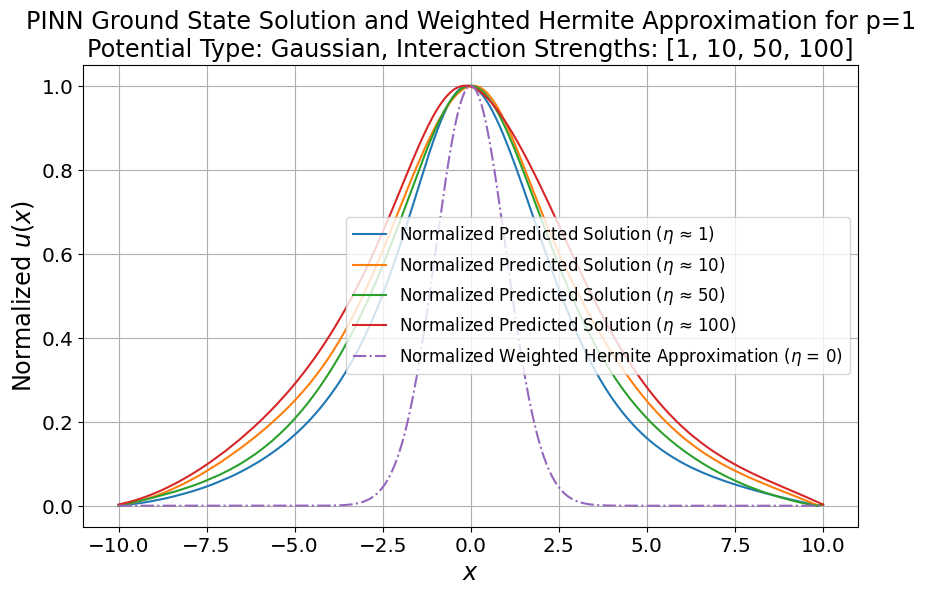

Epoch 0: λ_PDE = 1.839936, η = 1, Loss: 1283.873169
Epoch [0/10001], Loss: 1283.873169
Epoch 1000: λ_PDE = 2.104731, η = 1, Loss: 0.003330
Epoch 2000: λ_PDE = 2.104975, η = 1, Loss: 0.003268
Epoch 3000: λ_PDE = 2.105433, η = 1, Loss: 0.003227
Epoch 4000: λ_PDE = 2.106232, η = 1, Loss: 0.003191
Epoch 5000: λ_PDE = 2.107252, η = 1, Loss: 0.003153
Epoch 6000: λ_PDE = 2.108254, η = 1, Loss: 0.003121
Epoch 7000: λ_PDE = 2.109091, η = 1, Loss: 0.003097
Epoch 8000: λ_PDE = 2.109683, η = 1, Loss: 0.003083
Epoch 9000: λ_PDE = 2.110050, η = 1, Loss: 0.003075
Epoch 10000: λ_PDE = 2.110078, η = 1, Loss: 0.003074
Epoch [10000/10001], Loss: 0.003074
Epoch 0: λ_PDE = 8.014169, η = 10, Loss: 765.976562
Epoch [0/10001], Loss: 765.976562
Epoch 1000: λ_PDE = 7.447372, η = 10, Loss: 0.000555
Epoch 2000: λ_PDE = 7.439386, η = 10, Loss: 0.000160
Epoch 3000: λ_PDE = 7.437493, η = 10, Loss: 0.000149
Epoch 4000: λ_PDE = 7.436209, η = 10, Loss: 0.000141
Epoch 5000: λ_PDE = 7.434288, η = 10, Loss: 0.000131
Epoch

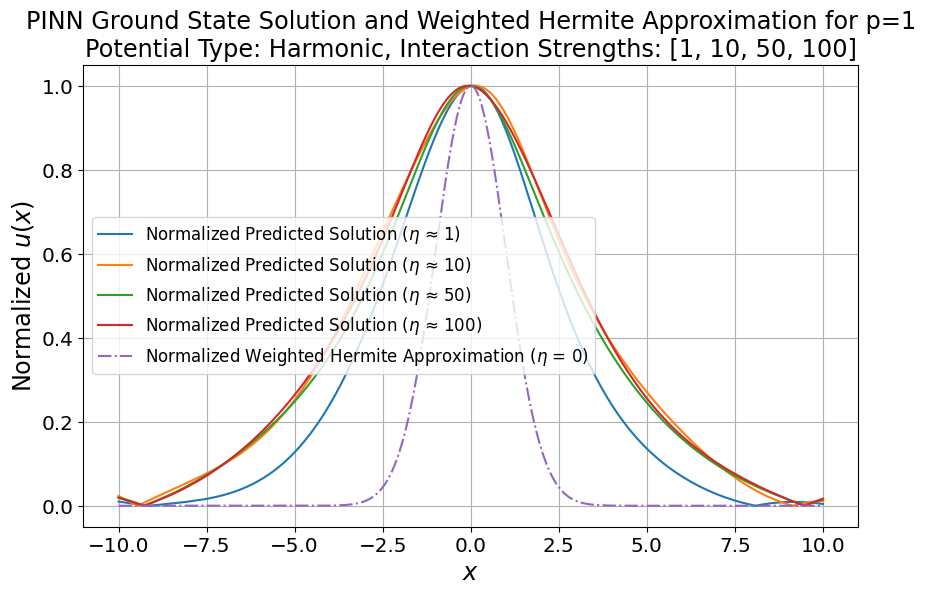

Epoch 0: λ_PDE = 1.712503, η = 1, Loss: 1673.335205
Epoch [0/10001], Loss: 1673.335205
Epoch 1000: λ_PDE = 2.092133, η = 1, Loss: 0.008020
Epoch 2000: λ_PDE = 2.091473, η = 1, Loss: 0.007996
Epoch 3000: λ_PDE = 2.091469, η = 1, Loss: 0.007996
Epoch 4000: λ_PDE = 2.091463, η = 1, Loss: 0.007996
Epoch 5000: λ_PDE = 2.091453, η = 1, Loss: 0.007995
Epoch 6000: λ_PDE = 2.091437, η = 1, Loss: 0.007995
Epoch 7000: λ_PDE = 2.091412, η = 1, Loss: 0.007994
Epoch 8000: λ_PDE = 2.091375, η = 1, Loss: 0.007993
Epoch 9000: λ_PDE = 2.091326, η = 1, Loss: 0.007992
Epoch 10000: λ_PDE = 2.091264, η = 1, Loss: 0.007990
Epoch [10000/10001], Loss: 0.007990
Epoch 0: λ_PDE = 7.546628, η = 10, Loss: 24667.892578
Epoch [0/10001], Loss: 24667.892578
Epoch 1000: λ_PDE = 7.854418, η = 10, Loss: 0.000488
Epoch 2000: λ_PDE = 7.854037, η = 10, Loss: 0.000298
Epoch 3000: λ_PDE = 7.853737, η = 10, Loss: 0.000282
Epoch 4000: λ_PDE = 7.853732, η = 10, Loss: 0.000282
Epoch 5000: λ_PDE = 7.853732, η = 10, Loss: 0.000282
E

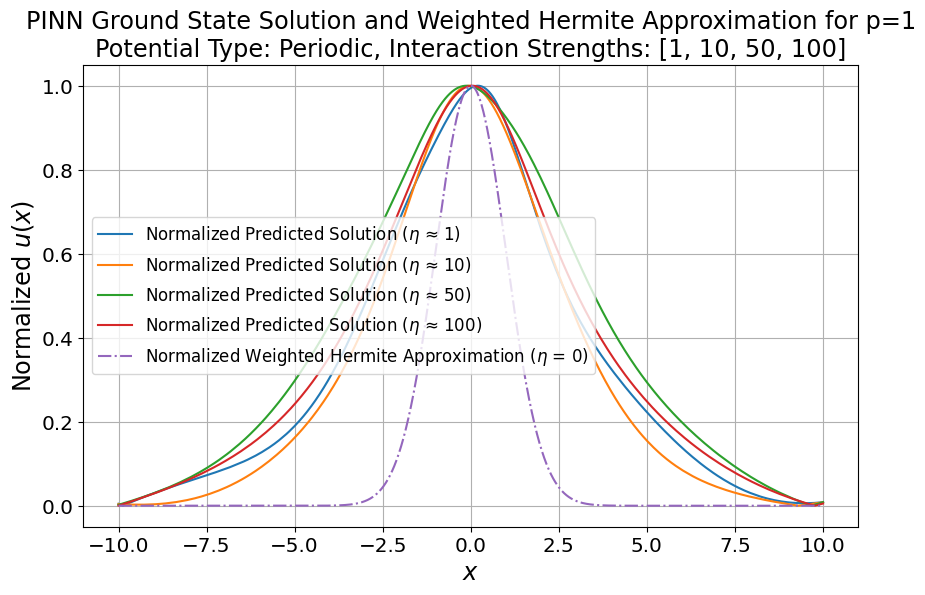

Epoch 0: λ_PDE = 2.664584, η = 1, Loss: 7502.958008
Epoch [0/10001], Loss: 7502.958008
Epoch 1000: λ_PDE = 3.091654, η = 1, Loss: 0.055893
Epoch 2000: λ_PDE = 3.091295, η = 1, Loss: 0.054962
Epoch 3000: λ_PDE = 3.090889, η = 1, Loss: 0.054051
Epoch 4000: λ_PDE = 3.090398, η = 1, Loss: 0.053071
Epoch 5000: λ_PDE = 3.089853, η = 1, Loss: 0.051991
Epoch 6000: λ_PDE = 3.089274, η = 1, Loss: 0.050782
Epoch 7000: λ_PDE = 3.088679, η = 1, Loss: 0.049442
Epoch 8000: λ_PDE = 3.088078, η = 1, Loss: 0.047981
Epoch 9000: λ_PDE = 3.087476, η = 1, Loss: 0.046402
Epoch 10000: λ_PDE = 3.086875, η = 1, Loss: 0.044707
Epoch [10000/10001], Loss: 0.044707
Epoch 0: λ_PDE = 8.809635, η = 10, Loss: 2931.842285
Epoch [0/10001], Loss: 2931.842285
Epoch 1000: λ_PDE = 8.824294, η = 10, Loss: 0.000128
Epoch 2000: λ_PDE = 8.825541, η = 10, Loss: 0.000042
Epoch 3000: λ_PDE = 8.825579, η = 10, Loss: 0.000034
Epoch 4000: λ_PDE = 8.825527, η = 10, Loss: 0.000033
Epoch 5000: λ_PDE = 8.825524, η = 10, Loss: 0.000033
Epo

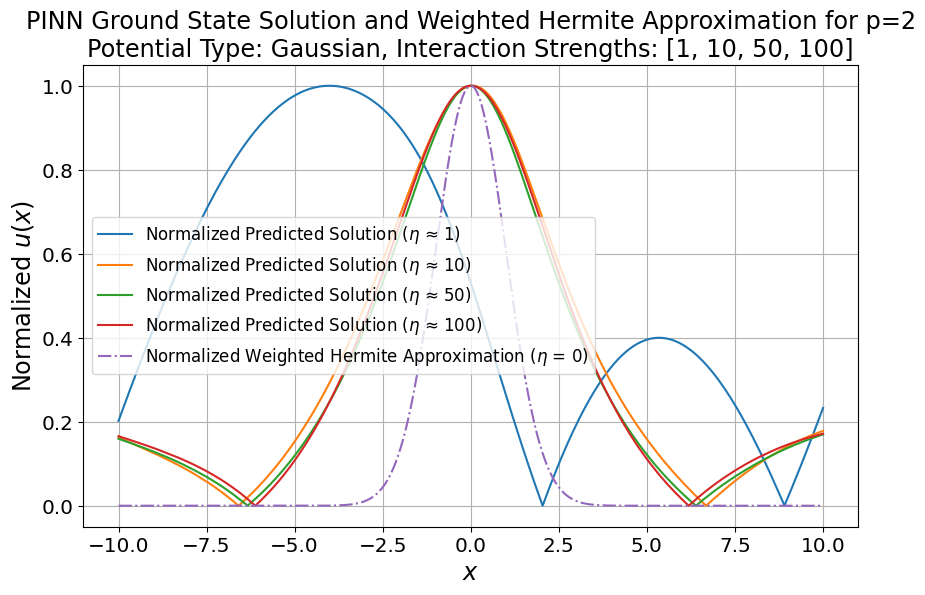

Epoch 0: λ_PDE = 2.712855, η = 1, Loss: 11676.107422
Epoch [0/10001], Loss: 11676.107422
Epoch 1000: λ_PDE = 3.131854, η = 1, Loss: 0.002996
Epoch 2000: λ_PDE = 3.130962, η = 1, Loss: 0.002908
Epoch 3000: λ_PDE = 3.130284, η = 1, Loss: 0.002867
Epoch 4000: λ_PDE = 3.129363, η = 1, Loss: 0.002820
Epoch 5000: λ_PDE = 3.128403, η = 1, Loss: 0.002780
Epoch 6000: λ_PDE = 3.127781, η = 1, Loss: 0.002757
Epoch 7000: λ_PDE = 3.126953, η = 1, Loss: 0.002730
Epoch 8000: λ_PDE = 3.126102, η = 1, Loss: 0.002707
Epoch 9000: λ_PDE = 3.125777, η = 1, Loss: 0.002700
Epoch 10000: λ_PDE = 3.125762, η = 1, Loss: 0.002699
Epoch [10000/10001], Loss: 0.002699
Epoch 0: λ_PDE = 6.625095, η = 10, Loss: 10785.687500
Epoch [0/10001], Loss: 10785.687500
Epoch 1000: λ_PDE = 8.438937, η = 10, Loss: 0.000809
Epoch 2000: λ_PDE = 8.429154, η = 10, Loss: 0.000621
Epoch 3000: λ_PDE = 8.420960, η = 10, Loss: 0.000544
Epoch 4000: λ_PDE = 8.411193, η = 10, Loss: 0.000466
Epoch 5000: λ_PDE = 8.400583, η = 10, Loss: 0.000386

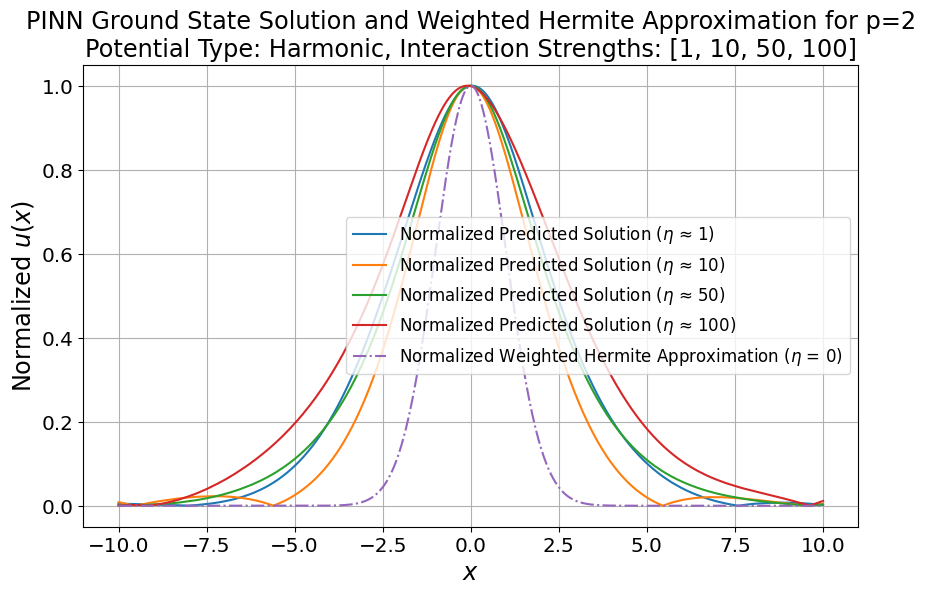

Epoch 0: λ_PDE = 2.887211, η = 1, Loss: 33.590580
Epoch [0/10001], Loss: 33.590580
Epoch 1000: λ_PDE = 3.132202, η = 1, Loss: 0.006682
Epoch 2000: λ_PDE = 3.132147, η = 1, Loss: 0.006679
Epoch 3000: λ_PDE = 3.132143, η = 1, Loss: 0.006679
Epoch 4000: λ_PDE = 3.132137, η = 1, Loss: 0.006679
Epoch 5000: λ_PDE = 3.132127, η = 1, Loss: 0.006679
Epoch 6000: λ_PDE = 3.132113, η = 1, Loss: 0.006678
Epoch 7000: λ_PDE = 3.132093, η = 1, Loss: 0.006678
Epoch 8000: λ_PDE = 3.132068, η = 1, Loss: 0.006677
Epoch 9000: λ_PDE = 3.132037, η = 1, Loss: 0.006676
Epoch 10000: λ_PDE = 3.131997, η = 1, Loss: 0.006675
Epoch [10000/10001], Loss: 0.006675
Epoch 0: λ_PDE = 9.715331, η = 10, Loss: 147.663849
Epoch [0/10001], Loss: 147.663849
Epoch 1000: λ_PDE = 8.844940, η = 10, Loss: 0.000007
Epoch 2000: λ_PDE = 8.844961, η = 10, Loss: 0.000001
Epoch 3000: λ_PDE = 8.844967, η = 10, Loss: 0.000000
Epoch 4000: λ_PDE = 8.844977, η = 10, Loss: 0.000000
Epoch 5000: λ_PDE = 8.844975, η = 10, Loss: 0.000000
Epoch 600

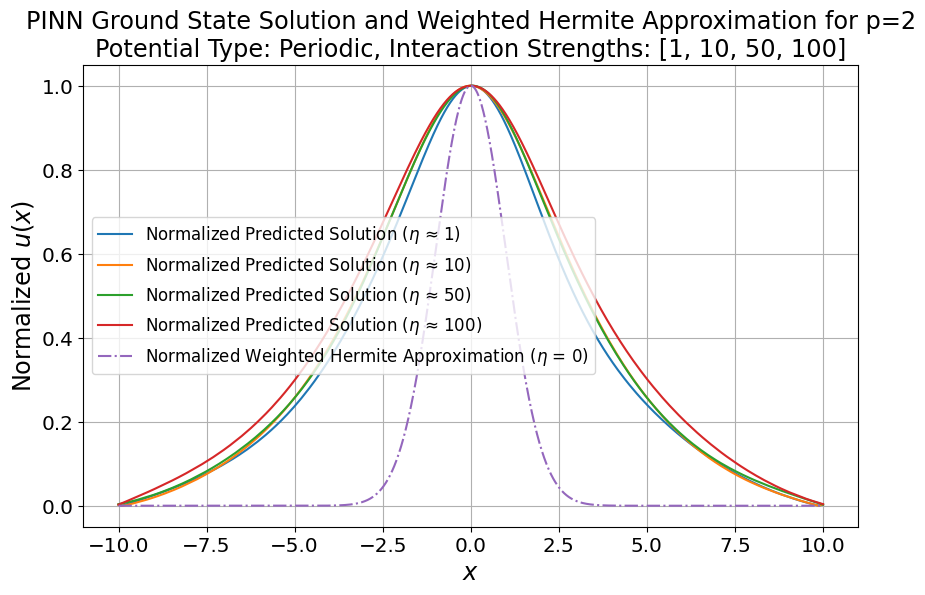

Epoch 0: λ_PDE = 3.694664, η = 1, Loss: 1663.292114
Epoch [0/10001], Loss: 1663.292114
Epoch 1000: λ_PDE = 4.146973, η = 1, Loss: 0.006998
Epoch 2000: λ_PDE = 4.146859, η = 1, Loss: 0.006993
Epoch 3000: λ_PDE = 4.146857, η = 1, Loss: 0.006993
Epoch 4000: λ_PDE = 4.146854, η = 1, Loss: 0.006993
Epoch 5000: λ_PDE = 4.146847, η = 1, Loss: 0.006992
Epoch 6000: λ_PDE = 4.146837, η = 1, Loss: 0.006992
Epoch 7000: λ_PDE = 4.146823, η = 1, Loss: 0.006992
Epoch 8000: λ_PDE = 4.146802, η = 1, Loss: 0.006991
Epoch 9000: λ_PDE = 4.146772, η = 1, Loss: 0.006990
Epoch 10000: λ_PDE = 4.146733, η = 1, Loss: 0.006989
Epoch [10000/10001], Loss: 0.006989
Epoch 0: λ_PDE = 8.258410, η = 10, Loss: 15648.441406
Epoch [0/10001], Loss: 15648.441406
Epoch 1000: λ_PDE = 9.880637, η = 10, Loss: 0.000037
Epoch 2000: λ_PDE = 9.880745, η = 10, Loss: 0.000005
Epoch 3000: λ_PDE = 9.880781, η = 10, Loss: 0.000004
Epoch 4000: λ_PDE = 9.880816, η = 10, Loss: 0.000003
Epoch 5000: λ_PDE = 9.880840, η = 10, Loss: 0.000002
E

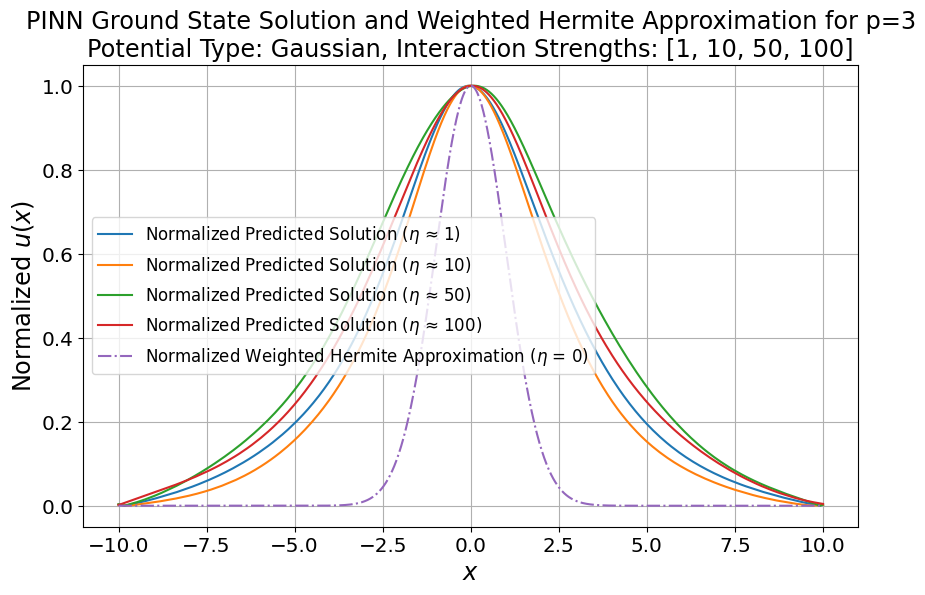

Epoch 0: λ_PDE = 3.806854, η = 1, Loss: 547.828796
Epoch [0/10001], Loss: 547.828796
Epoch 1000: λ_PDE = 4.099526, η = 1, Loss: 0.002927
Epoch 2000: λ_PDE = 4.098333, η = 1, Loss: 0.002827
Epoch 3000: λ_PDE = 4.097207, η = 1, Loss: 0.002780
Epoch 4000: λ_PDE = 4.096118, η = 1, Loss: 0.002744
Epoch 5000: λ_PDE = 4.095076, η = 1, Loss: 0.002717
Epoch 6000: λ_PDE = 4.094081, η = 1, Loss: 0.002696
Epoch 7000: λ_PDE = 4.093207, η = 1, Loss: 0.002682
Epoch 8000: λ_PDE = 4.092741, η = 1, Loss: 0.002675
Epoch 9000: λ_PDE = 4.092721, η = 1, Loss: 0.002675
Epoch 10000: λ_PDE = 4.092688, η = 1, Loss: 0.002674
Epoch [10000/10001], Loss: 0.002674
Epoch 0: λ_PDE = 11.965397, η = 10, Loss: 60.891361
Epoch [0/10001], Loss: 60.891361
Epoch 1000: λ_PDE = 9.376486, η = 10, Loss: 0.000632
Epoch 2000: λ_PDE = 9.370813, η = 10, Loss: 0.000476
Epoch 3000: λ_PDE = 9.365849, η = 10, Loss: 0.000437
Epoch 4000: λ_PDE = 9.359140, η = 10, Loss: 0.000392
Epoch 5000: λ_PDE = 9.352050, η = 10, Loss: 0.000345
Epoch 60

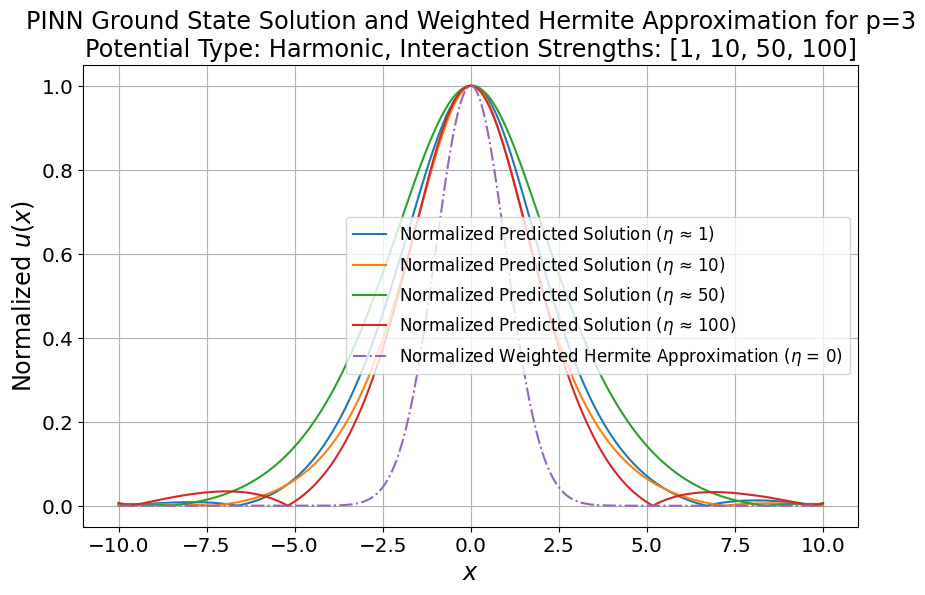

Epoch 0: λ_PDE = 3.679703, η = 1, Loss: 2943.706055
Epoch [0/10001], Loss: 2943.706055
Epoch 1000: λ_PDE = 4.160046, η = 1, Loss: 0.007413
Epoch 2000: λ_PDE = 4.159914, η = 1, Loss: 0.007395
Epoch 3000: λ_PDE = 4.159912, η = 1, Loss: 0.007394
Epoch 4000: λ_PDE = 4.159909, η = 1, Loss: 0.007394
Epoch 5000: λ_PDE = 4.159903, η = 1, Loss: 0.007394
Epoch 6000: λ_PDE = 4.159893, η = 1, Loss: 0.007393
Epoch 7000: λ_PDE = 4.159879, η = 1, Loss: 0.007393
Epoch 8000: λ_PDE = 4.159860, η = 1, Loss: 0.007391
Epoch 9000: λ_PDE = 4.159835, η = 1, Loss: 0.007390
Epoch 10000: λ_PDE = 4.159802, η = 1, Loss: 0.007388
Epoch [10000/10001], Loss: 0.007388
Epoch 0: λ_PDE = 8.793149, η = 10, Loss: 3034.313965
Epoch [0/10001], Loss: 3034.313965
Epoch 1000: λ_PDE = 9.387702, η = 10, Loss: 0.000077
Epoch 2000: λ_PDE = 9.387651, η = 10, Loss: 0.000030
Epoch 3000: λ_PDE = 9.387839, η = 10, Loss: 0.000028
Epoch 4000: λ_PDE = 9.387849, η = 10, Loss: 0.000028
Epoch 5000: λ_PDE = 9.387849, η = 10, Loss: 0.000028
Epo

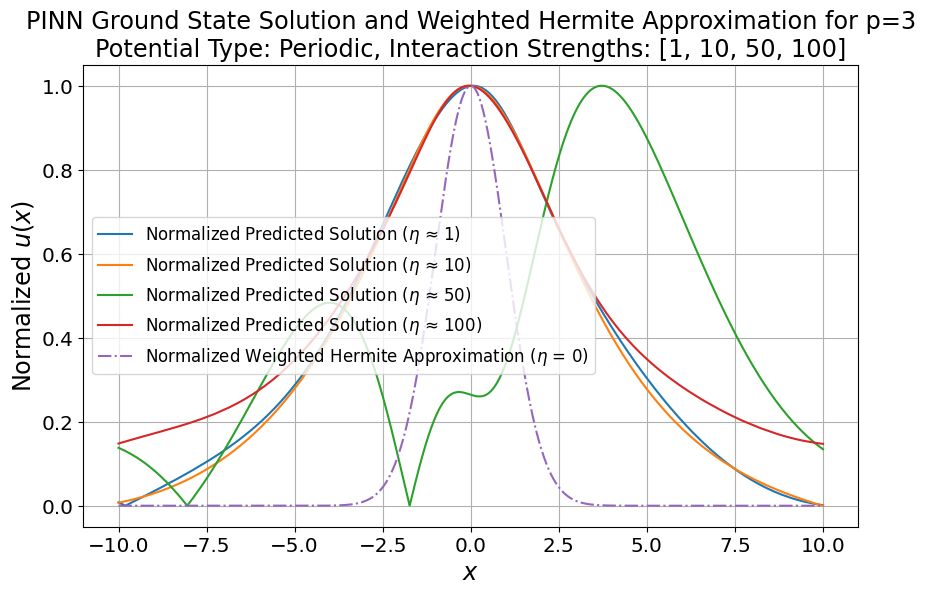

Epoch 0: λ_PDE = 4.655052, η = 1, Loss: 3944.841797
Epoch [0/10001], Loss: 3944.841797
Epoch 1000: λ_PDE = 5.122260, η = 1, Loss: 0.006608
Epoch 2000: λ_PDE = 5.122232, η = 1, Loss: 0.006605
Epoch 3000: λ_PDE = 5.122231, η = 1, Loss: 0.006605
Epoch 4000: λ_PDE = 5.122230, η = 1, Loss: 0.006605
Epoch 5000: λ_PDE = 5.122227, η = 1, Loss: 0.006605
Epoch 6000: λ_PDE = 5.122222, η = 1, Loss: 0.006605
Epoch 7000: λ_PDE = 5.122215, η = 1, Loss: 0.006604
Epoch 8000: λ_PDE = 5.122205, η = 1, Loss: 0.006604
Epoch 9000: λ_PDE = 5.122190, η = 1, Loss: 0.006603
Epoch 10000: λ_PDE = 5.122169, η = 1, Loss: 0.006602
Epoch [10000/10001], Loss: 0.006602
Epoch 0: λ_PDE = 9.634750, η = 10, Loss: 2262.080566
Epoch [0/10001], Loss: 2262.080566
Epoch 1000: λ_PDE = 10.396939, η = 10, Loss: 0.000043
Epoch 2000: λ_PDE = 10.397224, η = 10, Loss: 0.000035
Epoch 3000: λ_PDE = 10.397409, η = 10, Loss: 0.000035
Epoch 4000: λ_PDE = 10.397557, η = 10, Loss: 0.000034
Epoch 5000: λ_PDE = 10.397802, η = 10, Loss: 0.00003

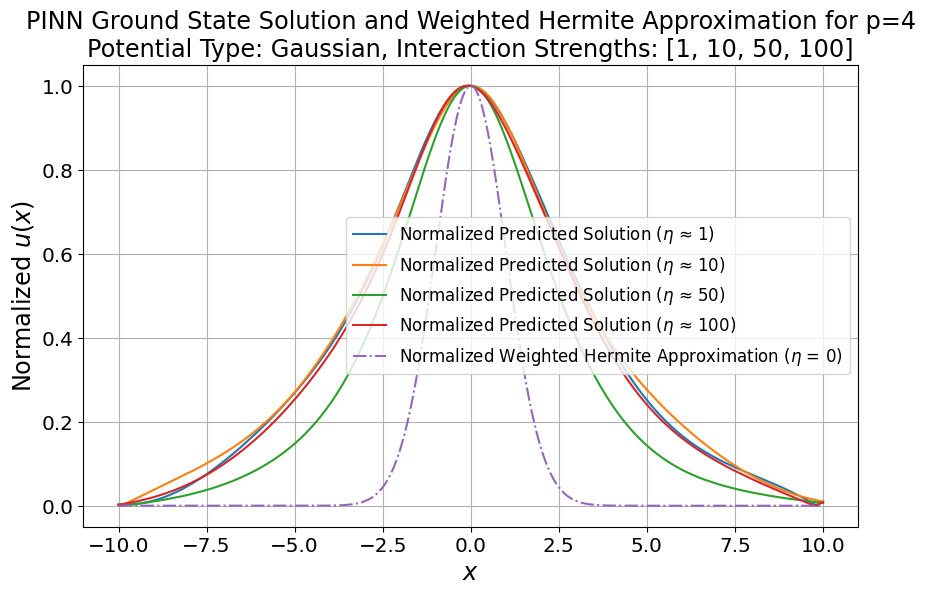

Epoch 0: λ_PDE = 4.719196, η = 1, Loss: 7650.022461
Epoch [0/10001], Loss: 7650.022461
Epoch 1000: λ_PDE = 5.119095, η = 1, Loss: 0.002631
Epoch 2000: λ_PDE = 5.117658, η = 1, Loss: 0.002557
Epoch 3000: λ_PDE = 5.115865, η = 1, Loss: 0.002479
Epoch 4000: λ_PDE = 5.114353, η = 1, Loss: 0.002426
Epoch 5000: λ_PDE = 5.112891, η = 1, Loss: 0.002385
Epoch 6000: λ_PDE = 5.111155, η = 1, Loss: 0.002345
Epoch 7000: λ_PDE = 5.109389, η = 1, Loss: 0.002313
Epoch 8000: λ_PDE = 5.107982, η = 1, Loss: 0.002293
Epoch 9000: λ_PDE = 5.106906, η = 1, Loss: 0.002280
Epoch 10000: λ_PDE = 5.106484, η = 1, Loss: 0.002275
Epoch [10000/10001], Loss: 0.002275
Epoch 0: λ_PDE = 9.193559, η = 10, Loss: 4585.906738
Epoch [0/10001], Loss: 4585.906738
Epoch 1000: λ_PDE = 10.865099, η = 10, Loss: 0.000158
Epoch 2000: λ_PDE = 10.867843, η = 10, Loss: 0.000138
Epoch 3000: λ_PDE = 10.872016, η = 10, Loss: 0.000119
Epoch 4000: λ_PDE = 10.877519, η = 10, Loss: 0.000096
Epoch 5000: λ_PDE = 10.883065, η = 10, Loss: 0.00007

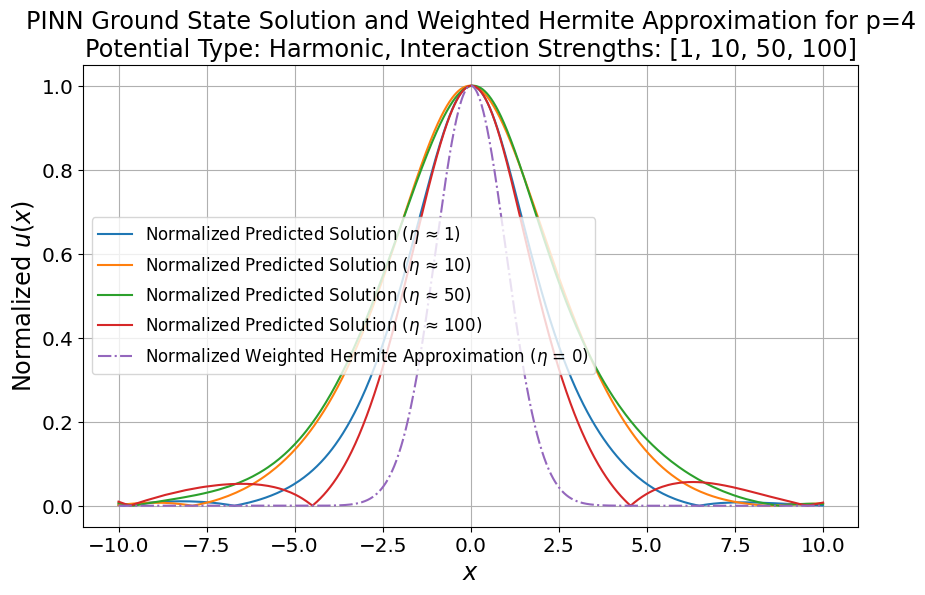

Epoch 0: λ_PDE = 4.696593, η = 1, Loss: 40229.601562
Epoch [0/10001], Loss: 40229.601562
Epoch 1000: λ_PDE = 5.109366, η = 1, Loss: 0.008224
Epoch 2000: λ_PDE = 5.109305, η = 1, Loss: 0.008220
Epoch 3000: λ_PDE = 5.109299, η = 1, Loss: 0.008219
Epoch 4000: λ_PDE = 5.109290, η = 1, Loss: 0.008219
Epoch 5000: λ_PDE = 5.109273, η = 1, Loss: 0.008219
Epoch 6000: λ_PDE = 5.109249, η = 1, Loss: 0.008218
Epoch 7000: λ_PDE = 5.109213, η = 1, Loss: 0.008218
Epoch 8000: λ_PDE = 5.109165, η = 1, Loss: 0.008217
Epoch 9000: λ_PDE = 5.109099, η = 1, Loss: 0.008215
Epoch 10000: λ_PDE = 5.109015, η = 1, Loss: 0.008214
Epoch [10000/10001], Loss: 0.008214
Epoch 0: λ_PDE = 12.320978, η = 10, Loss: 75.660492
Epoch [0/10001], Loss: 75.660492
Epoch 1000: λ_PDE = 10.407727, η = 10, Loss: 0.000086
Epoch 2000: λ_PDE = 10.408418, η = 10, Loss: 0.000003
Epoch 3000: λ_PDE = 10.408441, η = 10, Loss: 0.000003
Epoch 4000: λ_PDE = 10.408441, η = 10, Loss: 0.000003
Epoch 5000: λ_PDE = 10.408440, η = 10, Loss: 0.000003

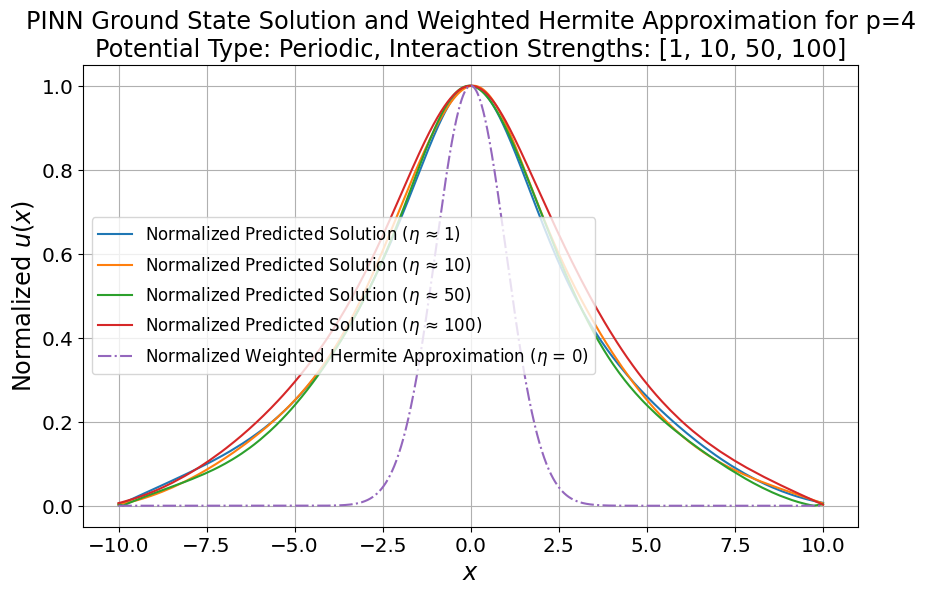

In [12]:
# Store all loss histories for different nonlinearity parameters
all_loss_histories = {}

potential_types = ['gaussian', 'harmonic', 'periodic']

# Loop through every nonlinearity power
nonlinearity_powers = [1,2,3,4]

for p in nonlinearity_powers:

    # Loop through each potential type
    for potential_type in potential_types:

        # Train and save models and loss history for different interaction strengths
        models = [] # Store all trained models
        prev_model = None  # For eta = 1, use the weighted hermite approximation
        loss_histories = []
        for eta in etas:
            model_save_path = f"trained_model_eta_{eta}.pth"
            model, loss_history = train_and_save_pinn(X, N_u=N_u, N_f=N_f, layers=layers, eta=eta, epochs=epochs, lb=lb, ub=ub,
                                                      weights=weights, model_save_path=model_save_path,
                                                      potential_type=potential_type, prev_model=prev_model, p=p)
            prev_model = model  # Store the trained model for the next iteration
            models.append(model)
            loss_histories.append(loss_history)

        # Store loss history for nonlinearity parameter p
        all_loss_histories[p] = loss_histories

        # Predict and plot the solutions for all models
        predict_and_plot(models, etas, X_test, p=p, save_path='plots/predicted_solutions_{potential_type}.png', potential_type=potential_type)

# Plot Loss Histories for Different Interaction Strengths and $p$

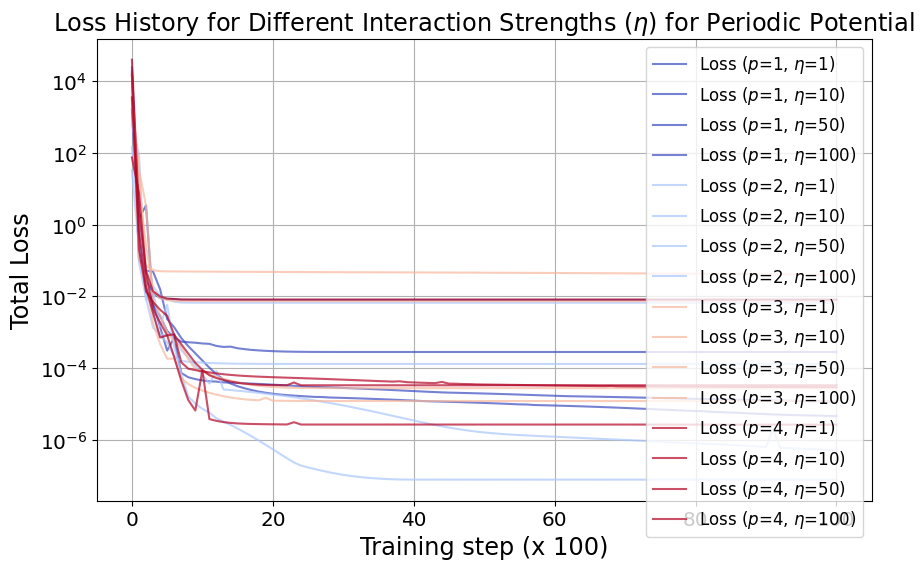

In [13]:
# Plot the loss history for all etas and all p
plot_loss_history(all_loss_histories, etas, nonlinearity_powers, save_path='plots/loss_history_{potential_type}.png', potential_type=potential_type)